[INFO] [1729995936.537209646] [rosbag2_storage]: Opened database '/home/rgautham20/lab4/data_going_in_circles.bag/data_going_in_circles.bag_0.db3' for READ_ONLY.


Loaded 5102 valid magnetic field measurements
EKF Calibration Results:
Bias: [-5.03807785e-06  2.62638700e-05  4.75097088e-05]


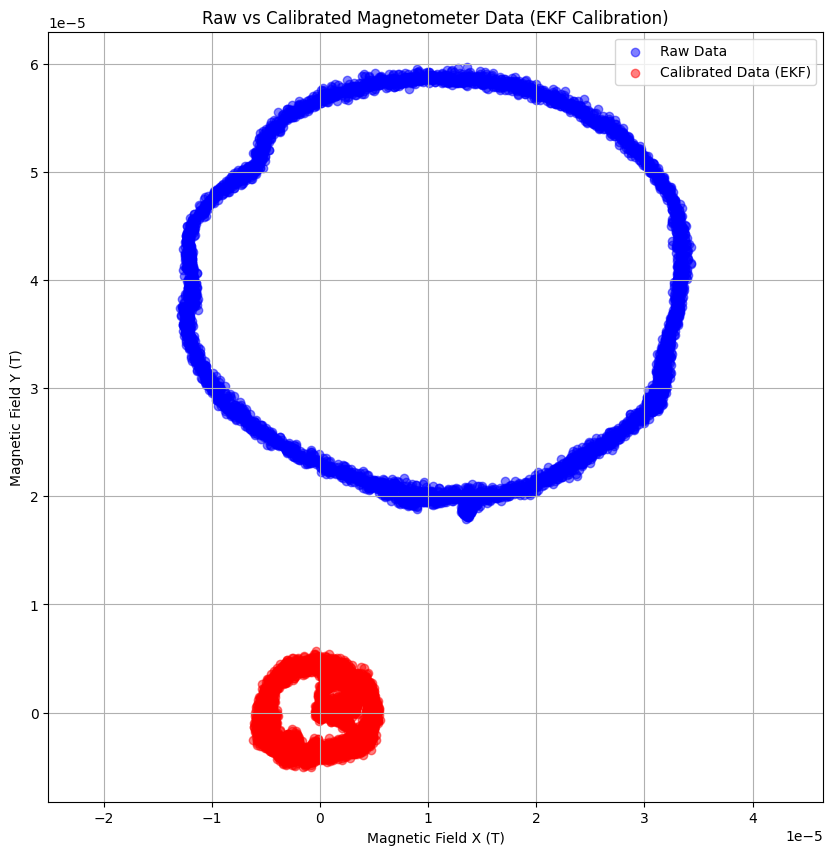

In [26]:
import rosbag2_py
from rclpy.serialization import deserialize_message
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
from rosidl_runtime_py.utilities import get_message

class MagnetometerCalibrator:
    def __init__(self):
        self.mag_data = []
    
    def read_rosbag(self, bag_path: str) -> None:
        """
        Read magnetometer data from a ROS2 bag file.
        Handles custom IMU message format with magnetic field data.
        """
        storage_options = rosbag2_py.StorageOptions(
            uri=bag_path,
            storage_id='sqlite3'
        )
        converter_options = rosbag2_py.ConverterOptions(
            input_serialization_format='cdr',
            output_serialization_format='cdr'
        )
        
        reader = rosbag2_py.SequentialReader()
        reader.open(storage_options, converter_options)
        
        topic_types = reader.get_all_topics_and_types()
        type_map = {topic_types[i].name: topic_types[i].type for i in range(len(topic_types))}
        
        while reader.has_next():
            topic_name, data, timestamp = reader.read_next()
            
            if '/imu' in topic_name:  # Adjust this to match your IMU topic name
                msg_type = type_map[topic_name]
                msg_class = get_message(msg_type)
                imu_msg = deserialize_message(data, msg_class)
                
                try:
                    mag_data = np.array([
                        imu_msg.mag_field.magnetic_field.x,
                        imu_msg.mag_field.magnetic_field.y,
                        imu_msg.mag_field.magnetic_field.z
                    ])
                    
                    if not np.any(np.isnan(mag_data)) and not np.any(np.isinf(mag_data)):
                        self.mag_data.append(mag_data)
                except AttributeError as e:
                    print(f"Error accessing magnetic field data: {e}")
                    raise
        
        self.mag_data = np.array(self.mag_data)
        print(f"Loaded {len(self.mag_data)} valid magnetic field measurements")

    def extended_kalman_filter_calibration(self) -> tuple:
        """
        Perform magnetometer calibration using Extended Kalman Filter (EKF).
        Returns: (bias, calibrated_data) tuple
        """
        # Initialize EKF
        ekf = KalmanFilter(dim_x=6, dim_z=3)
        ekf.x = np.zeros(6)  # Initial state (bias and scale factors)
        ekf.F = np.eye(6)    # State transition matrix
        ekf.H = np.hstack((np.eye(3), np.zeros((3, 3))))  # Observation matrix
        ekf.R = np.eye(3) * 0.1  # Measurement noise
        ekf.Q = np.eye(6) * 1e-4  # Process noise
        ekf.P = np.eye(6) * 10  # Covariance matrix

        calibrated_data = []
        for measurement in self.mag_data:
            # Predict step
            ekf.predict()
            # Update step
            ekf.update(measurement)

            # Apply calibration from state vector
            bias = ekf.x[:3]  # Hard iron bias
            scale = np.diag(ekf.x[3:] + 1)  # Soft iron scaling; added 1 to prevent scaling from going to zero

            # Apply bias and scale correction
            calibrated_measurement = scale @ (measurement - bias)
            calibrated_data.append(calibrated_measurement)

        return bias, np.array(calibrated_data)

    def plot_comparison(self, bias: np.ndarray, calibrated_data: np.ndarray) -> None:
        """
        Plot both raw and calibrated magnetometer data for comparison in a single plot.
        """
        plt.figure(figsize=(10, 10))
        plt.scatter(
            self.mag_data[:, 0],
            self.mag_data[:, 1],
            c='b',
            alpha=0.5,
            label='Raw Data'
        )
        plt.scatter(
            calibrated_data[:, 0],
            calibrated_data[:, 1],
            c='r',
            alpha=0.5,
            label='Calibrated Data (EKF)'
        )
        
        plt.title('Raw vs Calibrated Magnetometer Data (EKF Calibration)')
        plt.xlabel('Magnetic Field X (T)')
        plt.ylabel('Magnetic Field Y (T)')
        plt.legend()
        plt.grid(True)
        plt.axis('equal')
        plt.show()

def main():
    calibrator = MagnetometerCalibrator()
    
    bag_path = "/home/rgautham20/lab4/data_going_in_circles.bag/data_going_in_circles.bag_0.db3"  # Update with your bag file path
    calibrator.read_rosbag(bag_path)
    
    bias, calibrated_data = calibrator.extended_kalman_filter_calibration()
    
    print("EKF Calibration Results:")
    print(f"Bias: {bias}")
    
    calibrator.plot_comparison(bias, calibrated_data)

if __name__ == "__main__":
    main()
